# Tutorial 6 - Play with EIT using NRV

Here is an example of EIT reconstruction using pyEIT Jacobian reconstruction.

The tutrial is divided in 2 sections:
 - The forward problem: Measurement data are generated with FEM simulation (using [GMSH](https://gmsh.info/doc/texinfo/gmsh.html) and [FEniCSx](https://docs.fenicsproject.org) libraries) methods embedded in `nrv.eit.forward_problem`.
 - The forward problem: Image reconstruction is performed on the measurement data (using [pyEIT](https://github.com/eitcom/pyEIT)) methods implemented in `nrv.eit.inverse_problem`.

In [1]:
import sys
sys.path.append("../../NRV")
import nrv
import nrv.eit as eit
import numpy as np
import matplotlib.pyplot as plt
import os
from copy import deepcopy

import pyeit.eit.jac as jac
import pyeit.eit.protocol as protocol
import pyeit.mesh as mesh

test_id = "6"
res_dir  = f"./{test_id}/"

np.random.seed(102) # working

# np.random.seed(444) # not working


## Simulate Measure (*direct problem*)

#### Setting parameters



In [2]:

if os.cpu_count() > 20:
    n_proc_global = 10
else:
    n_proc_global = 3


l_fem = 1000 # um
l_elec = 300 # um
x_rec = 3000 # um
i_drive = 30 # uA
#dt_fem = 1 # ms
t_sim=10 # ms
t_iclamp = 0 # ms
n_fem_step = 10*n_proc_global
# dt_fem = [
#     (2.5, .5),
#     (8,.1),
#     (-1,.5),
#         ]# ms

dt_fem = [
    (2.5, .75),
    (8,.4),
    (-1,.75),
        ]

n_elec = 16


sigma_method = "mean"
inj_protocol_type = "simple"
use_gnd_elec = True
parameters = {"x_rec":x_rec,
"dt_fem":dt_fem,
"inj_protocol_type":inj_protocol_type,
"n_proc_global":n_proc_global,
"l_elec":l_elec,
"l_fem":l_fem,
"i_drive":i_drive,
"sigma_method":sigma_method,
"use_gnd_elec":use_gnd_elec,
"n_elec":n_elec,
}

Output()

NRV INFO: On 10 axons to generate, there are 0 Myelinated and 10 Unmyelinated


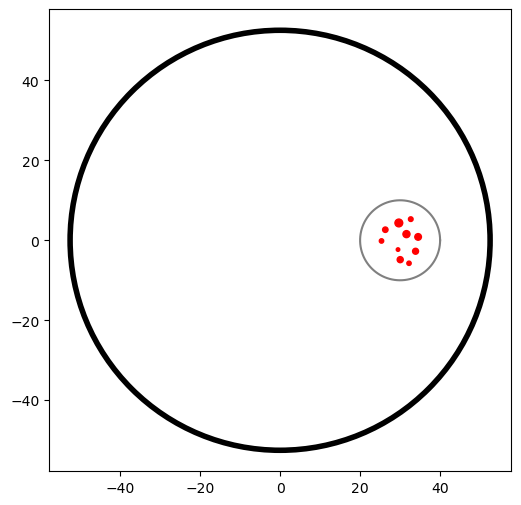

In [3]:
n_ax=10

outer_d = 5     # mm
nerve_d = 105  # um
nerve_l = 5010  # um
fasc1_d = 20   # um
fasc1_y = 30     # um
fasc1_z = 0     # um

percent_unmyel = 1
unmyelinated_nseg = 1000
axons_data={
    "diameters":[10.001],
    "types":[1],
    "y":[0],
    "z":[0],
}

nerve_1 = nrv.nerve(length=nerve_l, diameter=nerve_d, Outer_D=outer_d, postproc_label="sample_keys", record_g_mem=True)
fascicle_1 = nrv.fascicle(diameter=fasc1_d, ID=1, unmyelinated_nseg=unmyelinated_nseg)
fascicle_1.fill(n_ax=n_ax, percent_unmyel=percent_unmyel, M_stat="Ochoa_M", U_stat="Ochoa_U", fit_to_size=False,delta=1, delta_trace=3)
nerve_1.add_fascicle(fascicle=fascicle_1, y=fasc1_y, z=fasc1_z)

nerve_data = nerve_1.save(save=False)


fig, ax = plt.subplots(figsize=(6, 6))
nerve_1.plot(ax)
del nerve_1

#### Setup Problem geometry

EIT simulations can be done in three steps:

 1. **Nerve Simulation**: Simulation of the neural context.
 2. **Mesh Generation**: Creation of the problem geometry and physical domains.
 3. **EIT Simulation**: Simulation of the electric field inside the nerve for a given injection protocol.

All these steps can be done from a single ``eit.EIT2DProblem``-object.

Let's start by defining the problem using the parameter set before

In [4]:
eit_instance = eit.EIT2DProblem(nerve_data, res_dname=res_dir, label=test_id, **parameters)

Simulation is set 

In [5]:
## Nerve simulation
sim_param = {"t_sim":t_sim}
nrn_res = eit_instance.simulate_nerve(t_start=t_iclamp, sim_param=sim_param)

Output()

NRV INFO: Starting nerve simulation


NRV INFO: ...Done!


In [6]:
## Impedance simulation
eit_instance._define_problem()
# Build mesh
eit_instance.build_mesh()

NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of entities : 296
NRV INFO: Number of nodes : 3404
NRV INFO: Number of elements : 7005


In [7]:
# Simulate nerve
fem_res = eit_instance.simulate_eit()

Output()

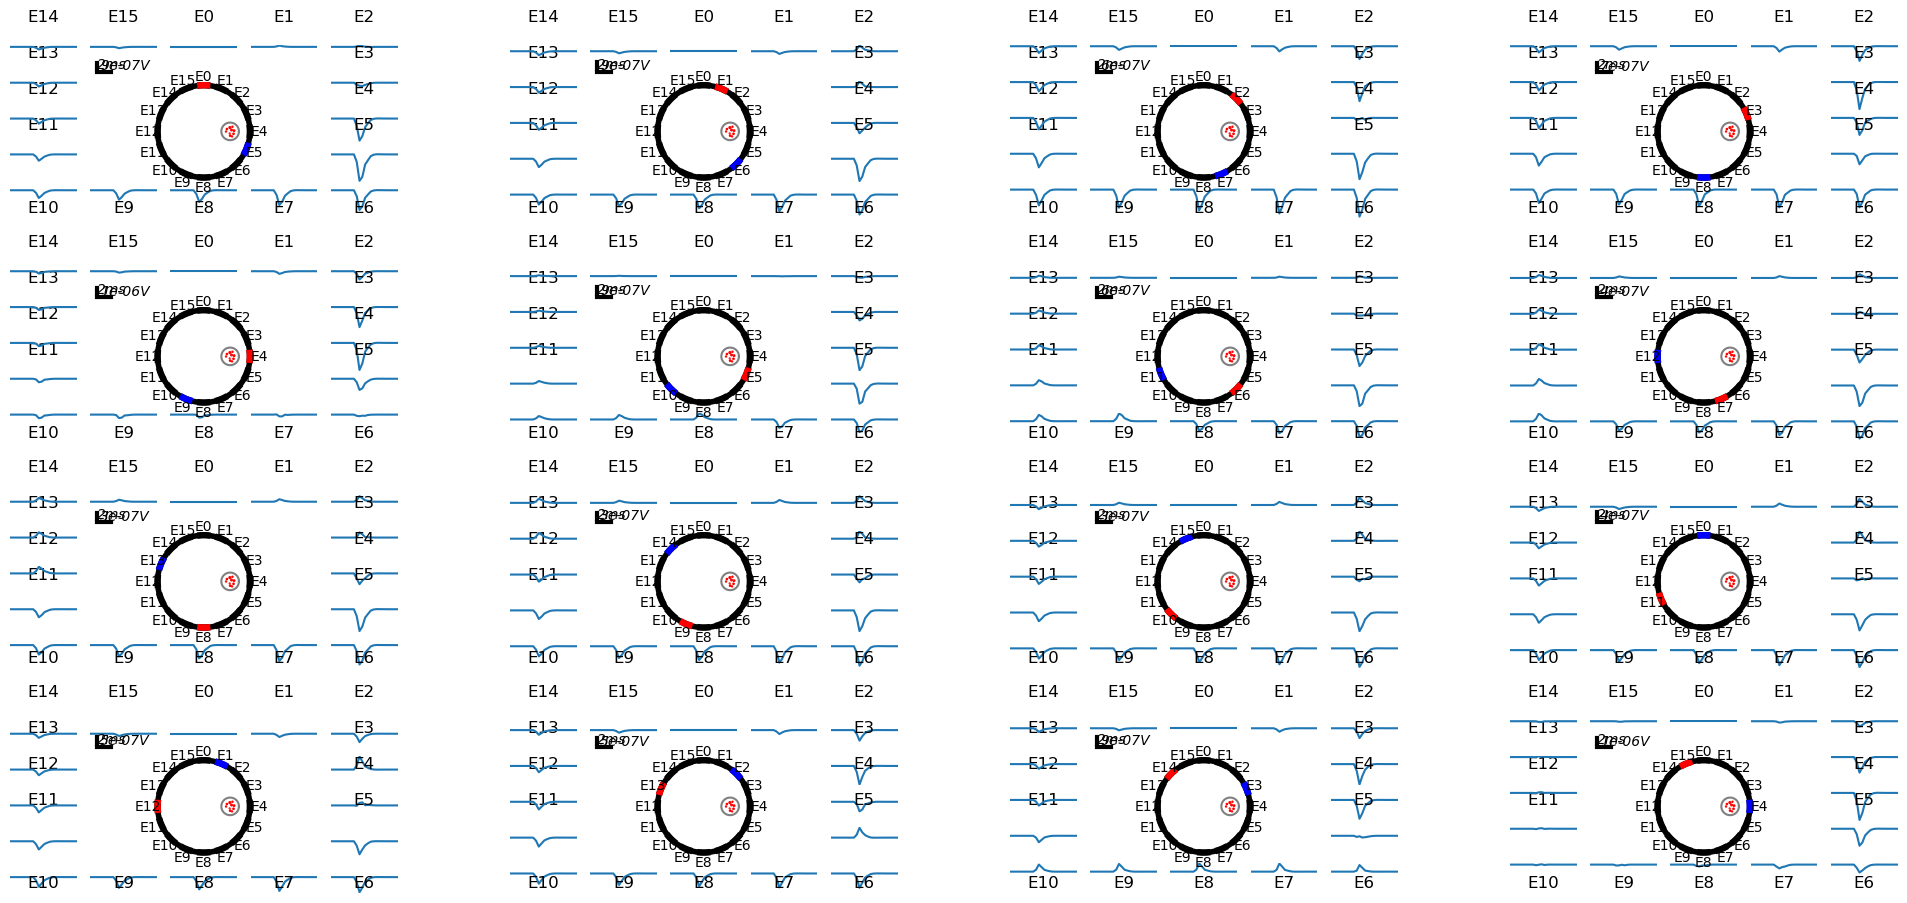

In [8]:
if n_elec in [8, 16]:
    fig = plt.figure(figsize=(20, 9))#, layout="constrained")
    subfigs = fig.subfigures(n_elec//4, 4)
    axs = np.array([])
    for i_p, pat in enumerate(fem_res["p"]):
        dv_pc = fem_res.dv_eit(i_p=i_p)#, signed=True)
        _, axs2 = eit.utils.gen_fig_elec(n_e=fem_res.n_e, fig=subfigs[i_p//4, i_p%4], small_fig=True)
        eit.utils.add_nerve_plot(axs=axs2, data=nerve_data, drive_pair=pat)
        eit.utils.plot_all_elec(axs=axs2, t=fem_res.t(), res_list=dv_pc,)
        axs = np.concatenate([axs, axs2[1:-1]])

        eit.utils.scale_axs(axs=axs2, e_gnd=[0], has_nerve=True)


The 2D voltage distribution of the last set of simulation can be plotted with *PyVista*.

In [9]:


eit_instance.run_and_savefem(sfile=res_dir+"test")
# udg_topology, udg_cell_types, udg_geometry = vtk_mesh(V)


# plotter = pyvista.Plotter(shape=(n_elec//4, 4), window_size=(2000,  1000))

# for i in range(n_elec):
#     if 1:#i not in [ 1, 2, 3, 4, 6, 7, 5]:
#         grid = pyvista.UnstructuredGrid(udg_topology, udg_cell_types, udg_geometry)

#         grid.point_data["u dg"] = uhs1[i].x.array.real
#         #print( uhs1[i].x.array.real)
#         grid.set_active_scalars("u dg")
#         plotter.subplot(i//4, i%4)
#         plotter.add_mesh(grid, show_edges=False)
#         plotter.add_text(f"injection E{i} to E{(i+inj_offset)%n_elec}")
#         plotter.view_yx()
# if not pyvista.OFF_SCREEN:
#     plotter.show()

(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (3,)), 0), Basix element (P, triangle, 2, gll_warped, unset, False, float64, [])),
 Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (3,)), 0), Basix element (P, triangle, 2, gll_warped, unset, False, float64, [])), 0),
 array([ 0.00000000e+00, -3.33667749e-07, -6.13114460e-07, -9.36102771e-07,
        -1.76969084e-06, -1.02543735e-06, -8.19019428e-07, -6.99847675e-07,
        -6.09250521e-07, -5.30420040e-07, -4.54365384e-07, -3.73461648e-07,
        -2.77573012e-07, -1.46357425e-07,  8.66679254e-08,  8.49606377e-07]))

## Reconstruct the image (*inverse problem*)

The reconstruction is adapted from the *Pyeit* [dynamic Jacobian example](https://github.com/eitcom/pyEIT/tree/master/examples).

The reconstruction consists of finding the conductivity distribution in a mesh that best matches the measurements. This adjustment is carried out using optimization algorithms and can be processed by *pyEIT* as follows.

First, the results must be formatted to be compatible with *PyEIT* (a 1D array containing the differential measurements in the correct order). The can be done using the ``extract_pyEIT_meas``-function

In [10]:
inv_pb = eit.pyeit_inverse(data=fem_res)
inv_pb.inj_offset

5

(16, 16)


Text(0.5, 1.0, 'Diferentrial measurements')

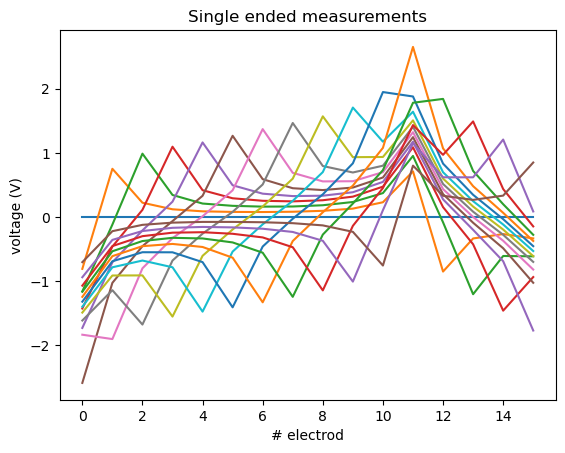

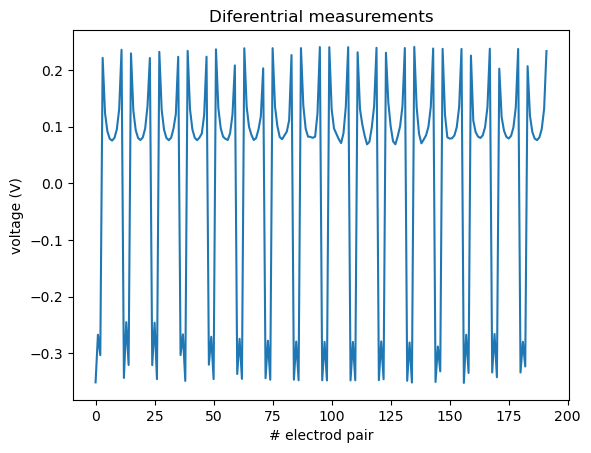

In [11]:
print(fem_res.v_eit(i_t=0,signed=True).shape)
plt.figure()
plt.plot(fem_res.v_eit(i_t=0,signed=True))

plt.xlabel("# electrod")
plt.ylabel("voltage (V)")
plt.title("Single ended measurements")
plt.figure()
plt.plot(inv_pb.fromat_data())
plt.xlabel("# electrod pair")
plt.ylabel("voltage (V)")
plt.title("Diferentrial measurements")

For this first test, only one image will be generated at the peak of the activity. 

The method used for reconstruction is dynamic, thus two set of measurement are required.

 - When the fibres are at rest `t=0` (``i_t=0``).
 - At the peek of activity `t=t_max`.

To find the index ``t_tmax`` a first trivial method consists at looking at the ``res.dv_eit`` as bellow of one electrode along time and find the minimal value

In [12]:
_dv = fem_res.dv_eit(i_e=fem_res.n_e//2, i_p=0,)

i_tmax = np.argmax(np.abs(_dv))

print(f"t_max={fem_res["t"][i_tmax]}ms, (i_tmax={i_tmax})")

t_max=4.099000000000448ms, (i_tmax=8)


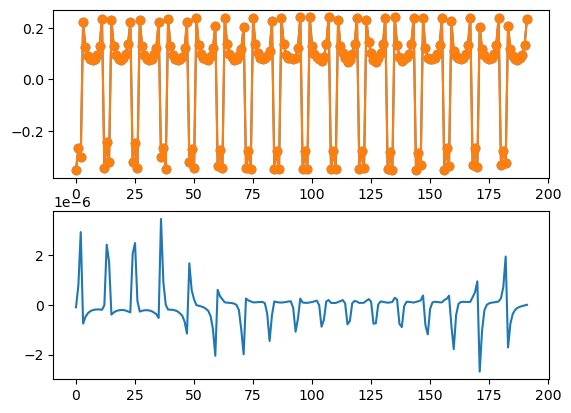

In [13]:
v0 = inv_pb.fromat_data(i_t=0)
v1 = inv_pb.fromat_data(i_t=i_tmax)

fig, axs = plt.subplots(2)
axs[0].plot(v0, "-o")
axs[0].plot(v1, "-o")

axs[1].plot(v1-v0)

Here is where the reconstruction is done. 

To reconstruct the images from the measurements the mesh and scan protocol have to be initialized in *Pyeit*

Then the solver object is defined and used on the two sets of measurements. 

In [14]:

# mesh_obj = mesh.create(fem_res.n_e, h0=0.025)
# protocol_obj = protocol.create(fem_res.n_e, dist_exc=5, step_meas=1, parser_meas="std")

# eit_invers = jac.JAC(mesh_obj, protocol_obj)
# eit_invers.setup(p=0.50, lamb=1e-3, method="kotre")
# ds = eit_invers.solve(v1, v0, normalize=True)

ds = inv_pb.solve(i_t=i_tmax)[0]



In [15]:
print(type(ds), ds.shape, inv_pb.mesh_obj.node.shape, inv_pb.mesh_obj.element.shape)
ds


<class 'numpy.ndarray'> (2821,) (1476, 3) (2821, 3)


array([-7.94072508e-06, -1.00106500e-05,  3.55060630e-05, ...,
       -2.74850503e-05, -3.36252834e-05, -3.66616246e-05])

Finally, the reconstruction can be plotted with `matplotlib` as bellow:

Text(0.5, 1.0, 'Reconstructed image')

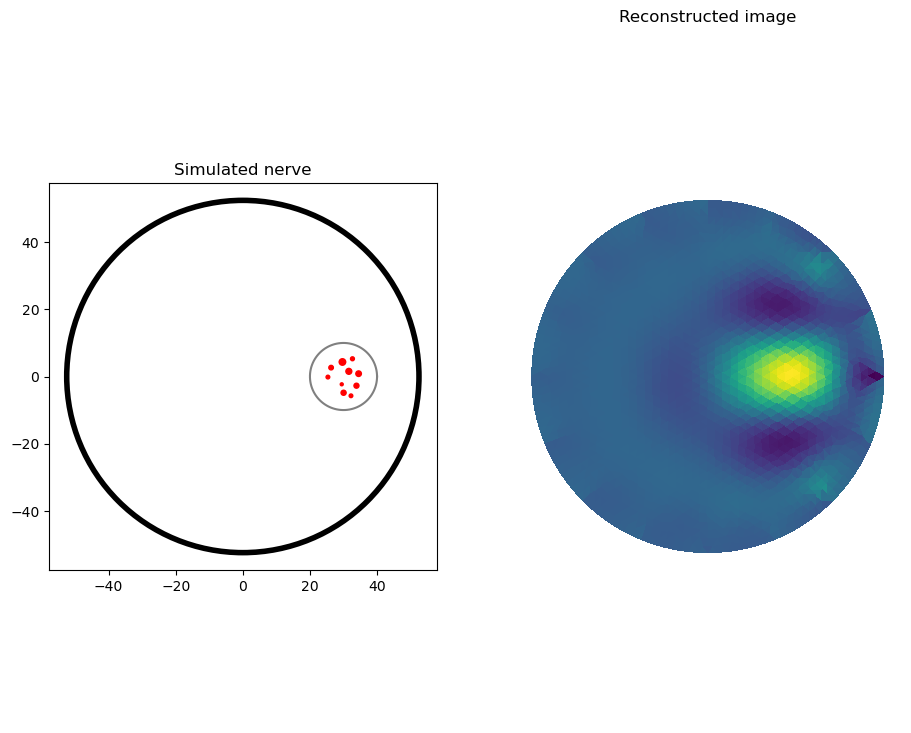

In [16]:
# draw
fig, axs2 = plt.subplots(1, 2, figsize=(11, 9))

ner = nrv.load_nerve(nerve_data)
ner.plot(axes=axs2[0])
axs2[0].set_title("Simulated nerve")

inv_pb.plot(ax=axs2[1], i_t=i_tmax)
axs2[1].set_title("Reconstructed image")


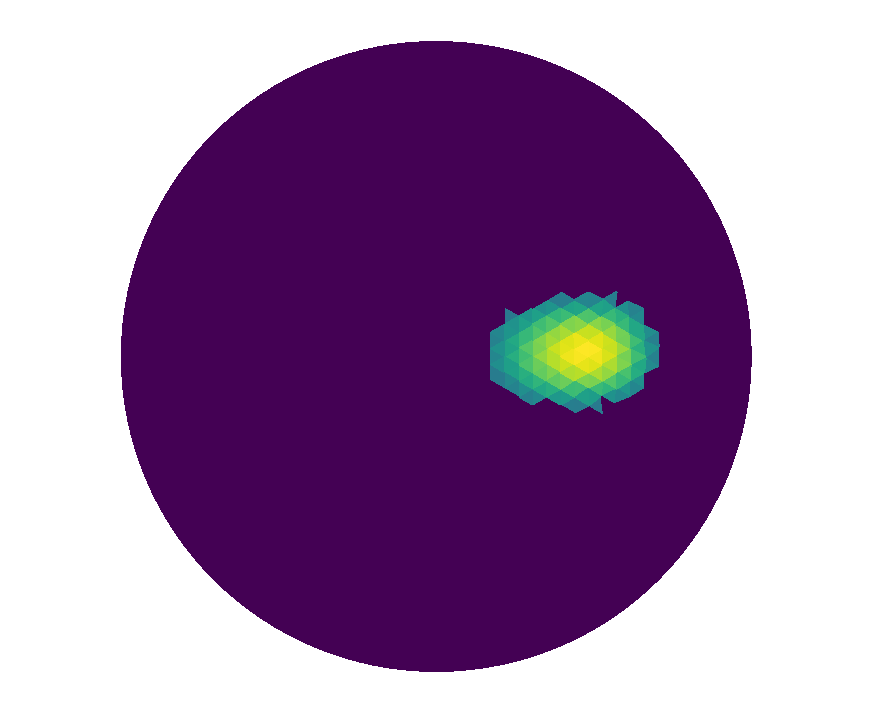

In [17]:
# draw
fig, ax2 = plt.subplots(figsize=(11, 9))

inv_pb.plot(ax=ax2, i_t=i_tmax, filter=eit.utils.thr_window)